In [6]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import datasets, model_selection, metrics
import scipy as sp

from functions_natalia import * 

# Print a confirmation message
print("Libraries imported successfully!")

Libraries imported successfully!


In [7]:
df_demo = pd.read_csv('../data/cleaned/df_final_demo_cleaned.csv')
df_demo.head()

,client_id,tenure_year,tenure_month,age,gender,number_of_accounts,balance,calls_6_month,logons_6_month
0,836976,6.0,73.0,60.5,U,2,45105.30,6,9
1,2304905,7.0,94.0,58.0,U,2,110860.30,6,9
2,1439522,5.0,64.0,32.0,U,2,52467.79,6,9
3,1562045,16.0,198.0,49.0,M,2,67454.65,3,6
4,5126305,12.0,145.0,33.0,F,2,103671.75,0,3


In [8]:
df_experiment = pd.read_csv('../data/cleaned/df_final_experiment_clients_cleaned.csv')
df_experiment.head()

,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


In [9]:
df_web = pd.read_csv('../data/cleaned/df_final_web_data_cleaned.csv')
df_web.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


## Convert date_time in correct format

In [10]:
def separate_and_concat_date_time(df):
    # Convert date_time column to datetime format
    df['date_time'] = pd.to_datetime(df['date_time'])
    
    # Extract date and time into separate columns
    df['date'] = df['date_time'].dt.date
    df['time'] = df['date_time'].dt.time
    
    # Concatenate date and time back into date_time
    df['date'] = pd.to_datetime(df['date'])
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
    df['date_time_new'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

    # Drop the intermediate date and time columns
    df = df.drop(columns=['date', 'time', 'date_time'])
    
    return df.head(20)

separate_and_concat_date_time(df_web)

,client_id,visitor_id,visit_id,process_step,date_time_new
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
5,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:17:15
6,9988021,580560515_7732621733,781255054_21935453173_531117,step_1,2017-04-17 15:17:01
7,9988021,580560515_7732621733,781255054_21935453173_531117,start,2017-04-17 15:16:22
8,8320017,39393514_33118319366,960651974_70596002104_312201,confirm,2017-04-05 13:10:05
9,8320017,39393514_33118319366,960651974_70596002104_312201,step_3,2017-04-05 13:09:43


## Calculate the total time spent by session

In [11]:
# Define a function to calculate the time difference
def calculate_time_diff(df_web):
    start_time = df_web.loc[df_web['process_step'] == 'start', 'date_time'].min()
    confirm_time = df_web.loc[df_web['process_step'] == 'confirm', 'date_time'].max()
    if pd.isna(start_time) or pd.isna(confirm_time):
        return pd.Timedelta(0)
    total_time_spent = confirm_time - start_time 
    return total_time_spent

calculate_time_diff(df_web)

Timedelta('97 days 23:24:52')

## Group by 'client_id','visitor_id', 'visit_id'

In [16]:
# Group by visit_id and apply the function
def get_total_time_spent(df):
    """
    This function groups the dataframe by visit_id, applies the calculate_time_diff function,
    and returns a dataframe with visit_id and total_time_spent columns.
    """
    total_time_spent = df.groupby(['client_id','visitor_id', 'visit_id']).apply(calculate_time_diff).reset_index()
    total_time_spent.columns = ['client_id','visitor_id', 'visit_id', 'total_time_spent']
    return total_time_spent.head(20)

get_total_time_spent(df_web)

/var/folders/76/0pntsdld7bg_p5gzgms4gghw0000gn/T/ipykernel_81311/4174502837.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_time_spent = df.groupby(['client_id','visitor_id', 'visit_id']).apply(calculate_time_diff).reset_index()


,client_id,visitor_id,visit_id,total_time_spent
0,169,201385055_71273495308,749567106_99161211863_557568,0 days 00:03:33
1,336,64757908_3400128256,649044751_80905125055_554468,0 days 00:00:00
2,546,475037402_89828530214,731811517_9330176838_94847,0 days 00:02:13
3,555,402506806_56087378777,637149525_38041617439_716659,0 days 00:02:38
4,647,66758770_53988066587,40369564_40101682850_311847,0 days 00:06:17
5,722,919259913_64837298108,984487154_55831795985_521110,0 days 00:09:59
6,786,439747392_30293505155,640294664_79662229470_499394,0 days 00:05:12
7,805,831412807_82548325803,451173196_11661340552_563345,0 days 00:00:00
8,805,831412807_82548325803,72221519_52513154978_430287,0 days 00:00:00
9,805,831412807_82548325803,905546080_75813398358_250101,0 days 00:00:00


In [17]:
# save to a new DataFrame
total_time_spent_df = get_total_time_spent(df_web)

/var/folders/76/0pntsdld7bg_p5gzgms4gghw0000gn/T/ipykernel_81311/4174502837.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_time_spent = df.groupby(['client_id','visitor_id', 'visit_id']).apply(calculate_time_diff).reset_index()


## Merge the time per session with Experiment table (Old and New Group)

In [18]:
# Merge the DataFrames on the 'client_id' column
total_time_spent_in_each_experiment = pd.merge(total_time_spent_df, df_experiment, on='client_id')

In [19]:
# Display the merged DataFrame
total_time_spent_in_each_experiment.head(20)

,client_id,visitor_id,visit_id,total_time_spent,variation
0,555,402506806_56087378777,637149525_38041617439_716659,0 days 00:02:38,Test
1,647,66758770_53988066587,40369564_40101682850_311847,0 days 00:06:17,Test
2,934,810392784_45004760546,7076463_57954418406_971348,0 days 00:00:00,Test
3,1028,42237450_62128060588,557292053_87239438319_391157,0 days 00:00:00,Control
4,1104,194240915_18158000533,543158812_46395476577_767725,0 days 00:00:00,Control
5,1104,194240915_18158000533,643221571_99977972121_69283,0 days 00:00:00,Control
6,1186,446844663_31615102958,507052512_11309370126_442139,0 days 00:00:00,Control
7,1186,446844663_31615102958,795373564_99931517312_810896,0 days 00:00:00,Control
8,1195,766842522_69992551638,393817425_39015278493_996341,0 days 00:04:05,Control
9,1197,753759429_54481946928,71862471_21202285428_848395,0 days 00:01:35,Control


## Bivariate : Categorical vs Continuous. 
Categorical vs Numerical Variable (category: Old/new design  vs time spent):

### Violin Plots : Old/new design  vs time spent
Combines a box plot with a kernel density plot to show the distribution of a continuous variable for each category.

/var/folders/76/0pntsdld7bg_p5gzgms4gghw0000gn/T/ipykernel_81311/727220914.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=total_time_spent_in_each_experiment, x='variation', y='total_time_spent', palette="coolwarm")


<Axes: xlabel='variation', ylabel='total_time_spent'>

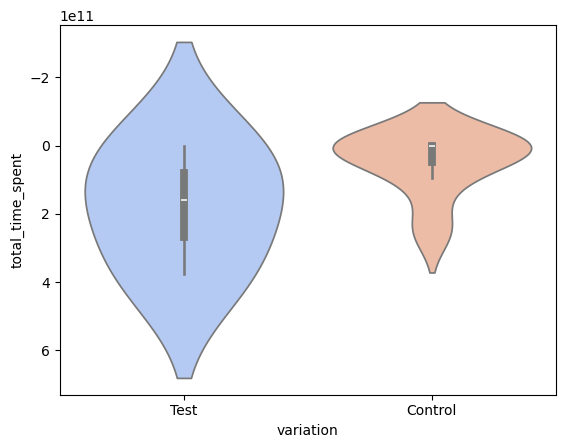

In [31]:
# Plotting a violin plot to visualize the distribution of 'SalePrice' for each 'MSZoning' category, using the "coolwarm" color palette
sns.violinplot(data=total_time_spent_in_each_experiment, x='variation', y='total_time_spent', palette="coolwarm")

### Bar Charts : Old/new design  vs time spent
Shows the mean (or another measure of central tendency) of the continuous variable for each category.

/var/folders/76/0pntsdld7bg_p5gzgms4gghw0000gn/T/ipykernel_81311/411434747.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=total_time_spent_in_each_experiment, x='variation', y='total_time_spent', palette="coolwarm")


<Axes: xlabel='variation', ylabel='total_time_spent'>

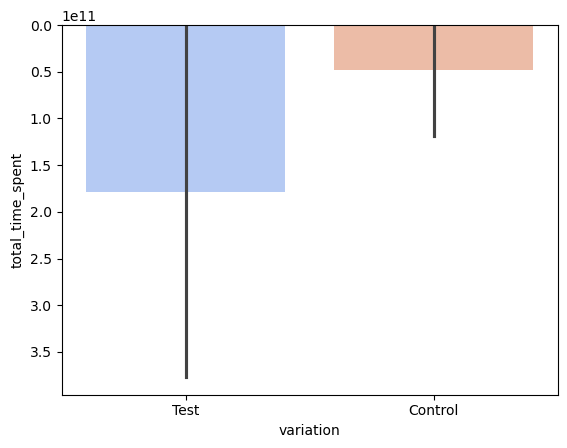

In [25]:
# Plotting a bar plot to visualize the average 'SalePrice' for each 'MSZoning' category, using the "coolwarm" color palette
sns.barplot(data=total_time_spent_in_each_experiment, x='variation', y='total_time_spent', palette="coolwarm")

### Side by Side Box Plots: Old/new design  vs time spent

Box plots are a great way to visualize the distribution of a continuous variable across different categories. They show the median, quartiles, and potential outliers, providing a quick snapshot of the data's spread and central tendency.

/var/folders/76/0pntsdld7bg_p5gzgms4gghw0000gn/T/ipykernel_81311/1774017780.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=total_time_spent_in_each_experiment, x='variation', y='total_time_spent', palette="coolwarm")


<Axes: xlabel='variation', ylabel='total_time_spent'>

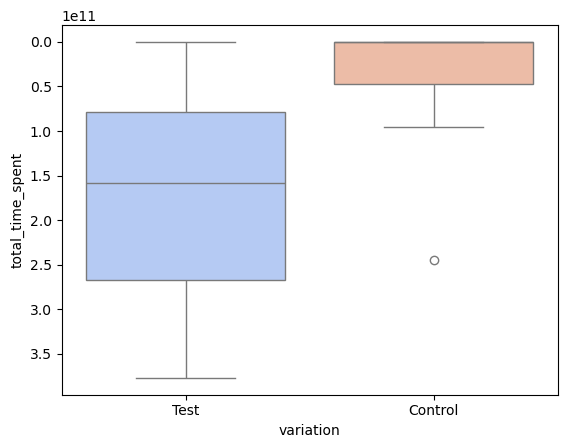

In [26]:
# Plotting a box plot to visualize the spread and outliers of 'SalePrice' for each 'MSZoning' category, using the "coolwarm" color palette
sns.boxplot(data=total_time_spent_in_each_experiment, x='variation', y='total_time_spent', palette="coolwarm")

## Univariate (total time spent per each test)

## Bar Chart

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
# Convert total_time_spent to total seconds
total_time_spent_in_each_experiment['total_time_spent_seconds'] = total_time_spent_in_each_experiment['total_time_spent'].dt.total_seconds()

/var/folders/76/0pntsdld7bg_p5gzgms4gghw0000gn/T/ipykernel_81311/2947719121.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=avg_total_time_spent, x='variation', y='total_time_spent_seconds', ci=None, palette="coolwarm")
/var/folders/76/0pntsdld7bg_p5gzgms4gghw0000gn/T/ipykernel_81311/2947719121.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_total_time_spent, x='variation', y='total_time_spent_seconds', ci=None, palette="coolwarm")


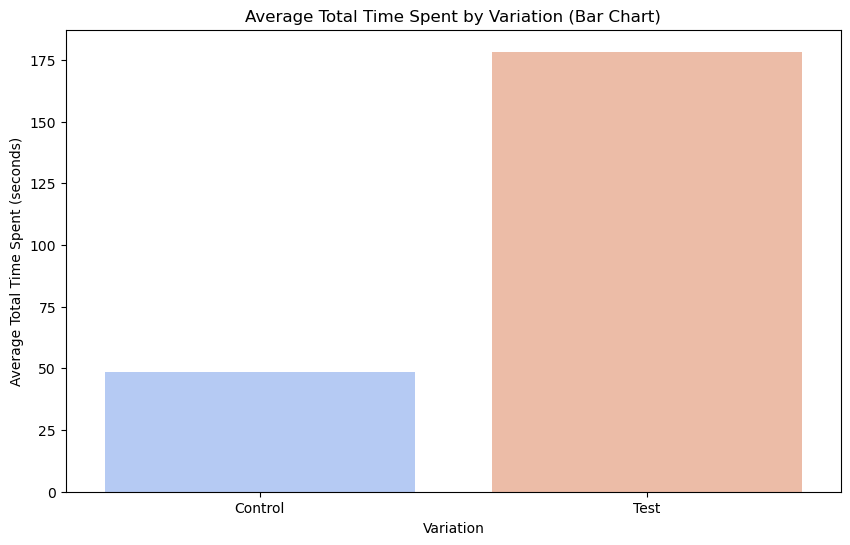

In [41]:
# Bar Chart (Average Total Time Spent)
plt.figure(figsize=(10, 6))
avg_total_time_spent = total_time_spent_in_each_experiment.groupby('variation')['total_time_spent_seconds'].mean().reset_index()
sns.barplot(data=avg_total_time_spent, x='variation', y='total_time_spent_seconds', ci=None, palette="coolwarm")
plt.title('Average Total Time Spent by Variation (Bar Chart)')
plt.xlabel('Variation')
plt.ylabel('Average Total Time Spent (seconds)')
plt.show()

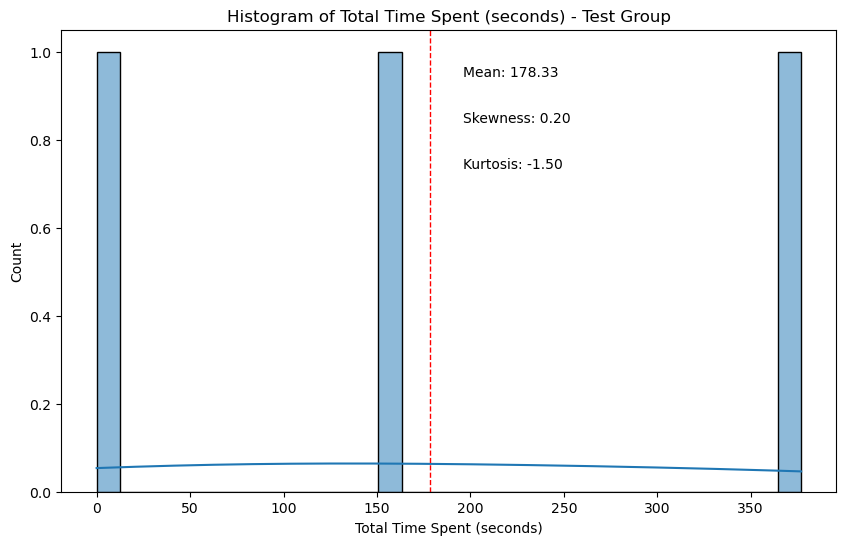

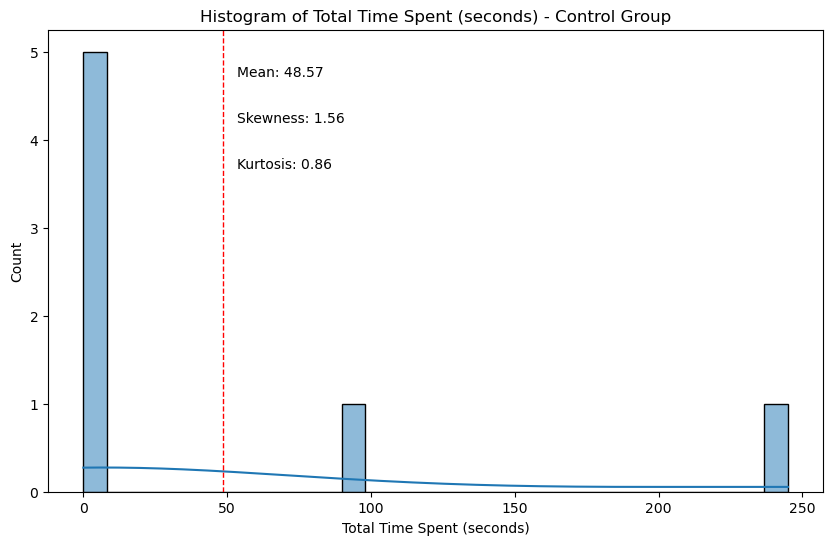

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# Assuming total_time_spent_in_each_experiment is already defined and contains the merged data
# Convert total_time_spent to total seconds if not already done
total_time_spent_in_each_experiment['total_time_spent_seconds'] = total_time_spent_in_each_experiment['total_time_spent'].dt.total_seconds()

# Split data into Test and Control groups
test_group = total_time_spent_in_each_experiment[total_time_spent_in_each_experiment['variation'] == 'Test']
control_group = total_time_spent_in_each_experiment[total_time_spent_in_each_experiment['variation'] == 'Control']

# Calculate skewness and kurtosis for Test group
skewness_test = skew(test_group['total_time_spent_seconds'].dropna())
kurt_test = kurtosis(test_group['total_time_spent_seconds'].dropna())

# Calculate skewness and kurtosis for Control group
skewness_control = skew(control_group['total_time_spent_seconds'].dropna())
kurt_control = kurtosis(control_group['total_time_spent_seconds'].dropna())

# Plotting the histogram for Test group
plt.figure(figsize=(10, 6))
sns.histplot(test_group['total_time_spent_seconds'], bins=30, kde=True)

# Adding skewness and kurtosis to the plot for Test group
plt.axvline(test_group['total_time_spent_seconds'].mean(), color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(test_group['total_time_spent_seconds'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(test_group['total_time_spent_seconds'].mean()))
plt.text(test_group['total_time_spent_seconds'].mean()*1.1, max_ylim*0.8, 'Skewness: {:.2f}'.format(skewness_test))
plt.text(test_group['total_time_spent_seconds'].mean()*1.1, max_ylim*0.7, 'Kurtosis: {:.2f}'.format(kurt_test))

plt.title('Histogram of Total Time Spent (seconds) - Test Group')
plt.xlabel('Total Time Spent (seconds)')
plt.ylabel('Count')
plt.show()

# Plotting the histogram for Control group
plt.figure(figsize=(10, 6))
sns.histplot(control_group['total_time_spent_seconds'], bins=30, kde=True)

# Adding skewness and kurtosis to the plot for Control group
plt.axvline(control_group['total_time_spent_seconds'].mean(), color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(control_group['total_time_spent_seconds'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(control_group['total_time_spent_seconds'].mean()))
plt.text(control_group['total_time_spent_seconds'].mean()*1.1, max_ylim*0.8, 'Skewness: {:.2f}'.format(skewness_control))
plt.text(control_group['total_time_spent_seconds'].mean()*1.1, max_ylim*0.7, 'Kurtosis: {:.2f}'.format(kurt_control))

plt.title('Histogram of Total Time Spent (seconds) - Control Group')
plt.xlabel('Total Time Spent (seconds)')
plt.ylabel('Count')
plt.show()

## Summary:
### Average Time Spent:
Users in the Test group spent significantly more time on average (178.33 seconds) compared to the Control group (48.57 seconds).

### Distribution Shape:

The Test group has a more symmetric distribution of time spent, whereas the Control group is heavily skewed to the right.

### Extreme Values:

The Control group has more extreme values (higher skewness and kurtosis) compared to the Test group, which indicates a few users spent significantly more time than others.

# Hypothesis testing


In [49]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

In [51]:
# Calculate mean time to completion for Test and Control groups
mean_time_to_completion = total_time_spent_in_each_experiment.groupby('variation')['total_time_spent'].mean().reset_index()
print(mean_time_to_completion)

  variation          total_time_spent
0   Control 0 days 00:00:48.571428571
1      Test 0 days 00:02:58.333333333


In [53]:
# Separate the data into Test and Control groups
test_group = total_time_spent_in_each_experiment[total_time_spent_in_each_experiment['variation'] == 'Test']['total_time_spent'].dropna()
control_group = total_time_spent_in_each_experiment[total_time_spent_in_each_experiment['variation'] == 'Control']['total_time_spent'].dropna()

# Perform independent t-test
t_stat, p_value = ttest_ind(test_group, control_group, equal_var=False)  # Using Welch's t-test which does not assume equal variance
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Check if p_value is less than significance level (e.g., 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis: The mean time to completion is different between Test and Control groups.")
else:
    print("Fail to reject the null hypothesis: The mean time to completion is not significantly different between Test and Control groups.")

ValueError: data type <class 'numpy.timedelta64'> not inexact

test_group = total_time_spent_in_each_experiment[total_time_spent_in_each_experiment['variation'] == 'Test']['time_spent_per_step'].dropna()
control_group = total_time_spent_in_each_experiment[total_time_spent_in_each_experiment['variation'] == 'Control']['time_spent_per_step'].dropna()